In [54]:
import string
import random
import csv
import torch
from torch.autograd import Variable
CHUNK_LEN = 200
import re
import matplotlib.ticker as ticker

# Configuration:

In [2]:
N_EPOCHS = 10000
PRINT_EVERY = 100
PLOT_EVERY = 10
HIDDEN_SIZE = 128
N_LAYERS = 1
LEARNING_RATE = 0.001
CHUNK_LEN = 200

# Data Understanding:

In [7]:
data = []
with open("new.txt", "r") as f:
    for line in f.readlines()[:10]:
        for x in line.split(' '):
            data.append(x)
f.close()

In [8]:
len(data)

7868

We have 7868 lines of data in total.

# Built words to indexes and indexes to word dicts:

In [10]:
class Lang(object):
    
    """
    build charecter to index and index to character dictionaries;
    get all unique words from underlying data and assign each word 
    with a unique index.
    """
    
    def __init__(self, filename):
        self.char2idx = {}
        self.idx2char = {}
        self.n_words = 0
        self.process(filename)

    def process(self, filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                words = set(line)
                comm = words & set(self.char2idx)
                for word in words:
                    if word not in comm:
                        self.char2idx[word] = self.n_words
                        self.idx2char[self.n_words] = word
                        self.n_words += 1

                        


In [ ]:
class Dataset(object):
    def __init__(self, filename):
        self.lang = Lang(filename)
        print(self.lang.idx2char)
        self.data = self.load_file(filename)

    def load_file(self, filename):
        data = []
        with open(filename, 'r') as f:
            data = f.read()
        return data

    def random_chunk(self, chunk_len = CHUNK_LEN):
        
        """
        Generate random chunk length(200) of data batch
        """
        start_idx = random.randint(0, len(self.data) - chunk_len)
        end_idx = start_idx + chunk_len + 1
        return self.data[start_idx:end_idx]

    def get_variable(self, string):
        
        """
        transfer words to index in tensor format by refering to char2idx dictionary
        """
        tensor = torch.zeros(len(string)).long()  # FloatTensor->LongTensor
        for c in range(len(string)):
            tensor[c] = self.lang.char2idx[string[c]]
        return Variable(tensor).cuda()

    def random_training_set(self):
        
        """
        input = all the words except the last one
        target = all the words except the first one
        """
        chunk = self.random_chunk()
        input = self.get_variable(chunk[:-1])
        target = self.get_variable(chunk[1:])
        return (input.cuda(), target.cuda())

# GRU Model implementation:

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    
    '''
    one layer RNN GRU model
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1, dropout_p=0.1):
        
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size).cuda()
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers).cuda()
        self.dropout = nn.Dropout(dropout_p)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        
        # input.view(1, -1) size of 1 * input_size（1 * 1）=> 1*1
        # input size => 1 * hidden_size (1 * 128)
        input = self.encoder(input.view(1, -1)).cuda()
        input = self.dropout(input)
        
        # input.view(1, 1, -1) size of seq_len x batch x input_size => 1 x 1 x input_size (1*1*128)
        # hidden size of n_layers x batch x hidden_size => n_layers x 1 x input_size (1*1*128)
        # output size of seq_len x batch x hidden_size * num_directions => 1 x 1 x hidden_size (1*1*128)
        output, hidden = self.gru(input.view(1, 1, -1), hidden)

        
        # output.view(1, -1) size =>  1 x hidden_size (1*128)
        # output size => 1 x output_size (1*(number of words in the vocabulary))
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self):
        
        # size self.n_layers x 1 x self.hidden_size (1*1*128)
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).cuda()


# Save and Load Model during training:

In [12]:
import time, math
import os, glob
import torch
import numpy as np

def time_since(since):
    
    '''
    record time
    '''
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m*60
    return '%dm %ds' % (m, s)

def save_model(model, epoch, max_keep=5):
    
    '''
    save model
    '''
    if not os.path.exists('./runtime'):
        os.makedirs('runtime')
    f_list = glob.glob(os.path.join('./runtime', 'model') + '-*.ckpt')
    if len(f_list) >= max_keep + 2:
        epoch_list = [int(i.split('-')[-1].split('.')[0]) for i in f_list]
        to_delete = [f_list[i] for i in np.argsort(epoch_list)[-max_keep:]]
        for f in to_delete:
            os.remove(f)
    name = 'model-{}.ckpt'.format(epoch)
    file_path = os.path.join('./runtime', name)
    torch.save(model.state_dict(), file_path)

def load_previous_model(model):
    
    '''
    load previous model
    '''
    f_list = glob.glob(os.path.join('./runtime', 'model') + '-*.ckpt')
    start_epoch = 1
    if len(f_list) >= 1:
        epoch_list = [int(i.split('-')[-1].split('.')[0]) for i in f_list]
        last_checkpoint = f_list[np.argmax(epoch_list)]
        if os.path.exists(last_checkpoint):
            print('load from {}'.format(last_checkpoint))
            if torch.cuda.is_available() == False:
                model.load_state_dict(torch.load(last_checkpoint, map_location='cpu'))
            else:
                model.load_state_dict(torch.load(last_checkpoint))
            start_epoch = np.max(epoch_list)
    return model, start_epoch

In [13]:
import os
import pickle
import string
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Train and Evaluate model:

In [14]:
def evaluate(model, dataset, prime_str='我只', predict_len = 100, temperature = 0.8):
    
    '''
    evaluate model, the prime_str can change to any word you want to start with.
    '''
    hidden = model.init_hidden()
    prime_input = dataset.get_variable(prime_str)
    predicted = prime_str
    for p in range(len(prime_str)-1):
        _, hidden = model(prime_input[p], hidden)
    input = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(input, hidden)
        output_dist = output.data.view(-1).div(temperature).exp() 
        #random draw one sample from the ouput multinomial distribution
        top_i = torch.multinomial(output_dist, 1)[0].item() # int
        #concat predicted output words together (length of 100)
        predicted_char = dataset.lang.idx2char[top_i] 
        predicted += predicted_char
        input = dataset.get_variable(predicted_char)
    return predicted

In [15]:
def train(model, optimizer, loss_fn, dataset, start_epoch=1):
    
    '''
    train model
    '''
    start = time.time()
    loss_avg = 0
    train_loss = []
    for epoch in range(start_epoch, N_EPOCHS+1):
        input, target = dataset.random_training_set()
        hidden = model.init_hidden()
        optimizer.zero_grad()
        loss = 0
        for c in range(CHUNK_LEN):
            #input one word each time and add up losses
            output, hidden = model(input[c], hidden)
            loss += loss_fn(output, target[c].unsqueeze(0))
        loss.backward()
        optimizer.step()
        each_loss_avg = loss.data[0] / CHUNK_LEN
        loss_avg += each_loss_avg
        if epoch % PRINT_EVERY == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch/N_EPOCHS*100, each_loss_avg))
            print(evaluate(model, dataset, '你要', 100),'\n')
            train_loss.append([epoch, each_loss_avg.item()])
            save_model(model, epoch)

    return train_loss
  
def generate(model, dataset, word, gen_len):
    print("gen> ", evaluate(model, dataset, word, gen_len))


    
path = 'data.pkl'
if not os.path.exists(path):
    with open(path, 'wb') as f:
        dataset = Dataset('new.txt')
        pickle.dump(dataset, f)
else:
    with open(path, 'rb') as f:
        dataset = pickle.load(f)
model = RNN(dataset.lang.n_words, HIDDEN_SIZE, dataset.lang.n_words, N_LAYERS).cuda()
model, start_epoch = load_previous_model(model)
##Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
##loss function
loss_fn = nn.CrossEntropyLoss()
train_loss = train(model, optimizer, loss_fn, dataset, start_epoch=start_epoch)
    




{0: '块', 1: '速', 2: '鲁', 3: '妆', 4: '糖', 5: '植', 6: '莉', 7: '骷', 8: '妈', 9: '倒', 10: '蜂', 11: '炫', 12: '荫', 13: '好', 14: '些', 15: '凄', 16: '嘴', 17: '福', 18: '州', 19: '顺', 20: '准', 21: '瓶', 22: '堕', 23: '桠', 24: '备', 25: '凑', 26: '鹿', 27: '保', 28: '士', 29: '惹', 30: '土', 31: '壳', 32: '无', 33: '痹', 34: '嘟', 35: '果', 36: '哮', 37: '启', 38: '痕', 39: '憔', 40: '我', 41: '别', 42: '抛', 43: '乔', 44: '眷', 45: '劫', 46: '绕', 47: '式', 48: '奔', 49: '巢', 50: '龙', 51: '击', 52: '乌', 53: '觉', 54: '朦', 55: '运', 56: '愈', 57: '技', 58: '扮', 59: '室', 60: '认', 61: '蛮', 62: '挡', 63: '梯', 64: '挣', 65: '乎', 66: '淡', 67: '仰', 68: '暴', 69: '答', 70: '扬', 71: '夸', 72: '辛', 73: '站', 74: '机', 75: '牛', 76: '杖', 77: '拜', 78: '克', 79: '奸', 80: '影', 81: '咏', 82: '怪', 83: '躲', 84: '喵', 85: '斜', 86: '废', 87: '家', 88: '穗', 89: '整', 90: '还', 91: '性', 92: '身', 93: '酸', 94: '宅', 95: '万', 96: '箭', 97: '寺', 98: '苍', 99: '截', 100: '护', 101: '缘', 102: '尚', 103: '瑰', 104: '单', 105: '龟', 106: '鸟', 107: '育', 108: '淌', 109: '念', 110: '版',

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


 42s (100 1%) 6.1212]
你要萍仙只香的赶 旧的 你在你的去 你中 成唐好 快临好 开等要鳅 样牛哇这状 太 你边妆啊 公爱 太我不跟 是的一你 你的顺照 的画 始你单状 简我在一 你不里 甜 欢欢放要我不 我说我的 一 实我雨  

 25s (200 2%) 5.6198]
你要没见只换别 我的访 我的经 我歌缓体 就你的声一耍 你执要 要算多以 这后好 在说你的我断面 我在心我 活道你的沙 在叽还梦 就不要我 你么不的感 喜所你 跟的遍能开 我再敲 一再我说我爱回 我们人怀 

 7s (300 3%) 5.7266]
你要了想 表靠却 你你 天的 我不这跟冬很你 再太 真的 回月你的梦 一息事 你还没别喜的来间 很 我来我 海我用降落事 法天你的动是可 指我会我烦那法园身吧 反我 你才 我了我的围了 我们天就你的眼 美 

 47s (400 4%) 5.6091]
你要等势定 你在我的朵终是打当 我 爱我的都 爱你的嘴了 仔事不来 给你懂 我说我 你太不反 你的小得停在的随乱分干很秀 我手 不掉有从然不麻 是一个足你的箭爱有你 爱在响不大待 梦着双来不悔 像风义 我 

 27s (500 5%) 4.9142]
你要起开了你 的嘴 在你说的眼望存多 我是爱千不能不到 但事草有你关 你说的麻 不能说 你的微笑 还是我所时离的 被不是 我手得 在叫性 很夏想生运 一气 我翻的凑情 我动一个人 三什么分 我的眼 我想要 

 9s (600 6%) 5.4633]
你要在一我不对 我我却不送一路情的榻声 柴你会难过 侵的海黑 迎时边上你承 我弟要拿术离开一直喊台你再寞上摆 为什么我睛会想 大来 所五扬 不懂成的老 插没有的鸦大树挤 我你以样天嫌脆 这样跑投的美 或滴 

 48s (700 7%) 5.2461]
你要想活白 像间气 初回忆的时候日石山 你爱你 我不能听收地功 你存想女还要 如果白 想我有一谢记会专 浅继续了 我哭 这还是我不会有夹一直的 条 东带风米持的人 光之相嘲光赏 我们的阳言 你乡你的感觉  

 28s (800 8%) 4.5632]
你要喝掉 只好对着 击声时候 美结阳后喜欢的手 一点让不是我就不知道 你不神 让我 就不能够的放开 就算不要看放弃 卑许的爱跳 你也许 我的心 还仍要在老我在永界 不是起 你 我在隔

# Training Performace:

In [49]:
with open("train_loss.pkl", 'rb') as f:
    train_loss  = pickle.load(f)
    f.close()

In [50]:
epochs = [i[0] for i in train_loss]
loss = [i[1] for i in train_loss]

<Figure size 432x288 with 0 Axes>

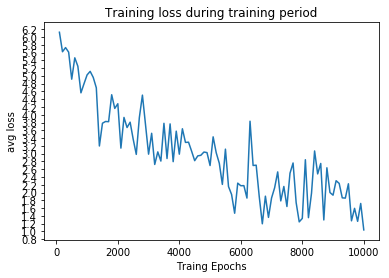

In [52]:
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(epochs, loss)
plt.xlabel('Traing Epochs')
plt.ylabel('avg loss')
plt.title('Training loss during training period.')
plt.show()

# Try it out result:

In [17]:
path = 'data.pkl'
with open(path, 'rb') as f:
    dataset = pickle.load(f)

In [23]:
# You can change the start words “你好” with words you want.

model = RNN(dataset.lang.n_words, HIDDEN_SIZE, dataset.lang.n_words, N_LAYERS).cuda()
model, start_epoch = load_previous_model(model)
print(evaluate(model, dataset, '你好', 100),'\n')

load from ./runtime/model-10000.ckpt
你好久 未来也许下的内容 你也走吧 你说选我太多了 就说你不轻 如何记得我也能 抹果我都指上 你是冬天 叫做爱你回家的是寂寞 日子你眼睛你在一起 你我不在我深深深倒抽一口气全泪我如何遗懂 春庭满纸笔 四天 

